In [1]:
import os
import subprocess
import sys
import numpy as np
import itertools
import json
from tqdm import tqdm
from IPython.display import display, HTML
import time
import copy
from collections import namedtuple
top_level_dir = '/'.join( os.getcwd().split( '/' )[ :-2 ] )
if top_level_dir not in sys.path:
    sys.path.append( top_level_dir )
%load_ext autoreload
%autoreload 2
display(HTML("<style>.container { width:100% !important; }</style>"))

# Hidden Markov Model Analysis

The most basic way that this problem can be modeled is using graphical hidden markov models.

Let *f* denote females, *m* denote males and *u* denote nodes with an unknown sex. <br>
In addition, let d(.) be a function that returns the latent state size of the input
<br><br>
For every root in the pedigree
$$
f_x \sim \pi_{f_0} \\
m_x \sim \pi_{m_0}
$$
For every child *c* in the pedigree with mother *f* and father *m*
<br>
&nbsp;&nbsp;&nbsp;&nbsp;For i=1...d(f), j=1...d(m), k=1...d(c)
$$
c_{x_k} \sim \pi_{ijk}f_{x_i}m_{x_j} \\
$$
For each node *n*
<br>
&nbsp;&nbsp;&nbsp;&nbsp;For i=1...d(n)
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;If n is female:
$$
n_{y_j} \sim L_{f_ij}n_{x_i}
$$
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;If n is male:
$$
n_{y_j} \sim L_{m_ij}n_{x_i}
$$
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;If n is unknown:
$$
n_{y_j} \sim L_{u_ij}n_{x_i}
$$

Each of the parameters will have a different Dirichlet prior over their last axis.  The root distributions will have a weak prior as there is no way of knowing what their distribution can be and the transition and emission distributions will have priors determined by [Mendelian Inheritance](https://en.wikipedia.org/wiki/Mendelian_inheritance) depending on the model.  The prior (with strength included) will be called *G* and *H* respectively.  There will be an *H* for each different sex
$$
\pi_{\{.\}_0} \sim \text{Dirichlet}( 1 ) \\
\pi_{ij} \sim \text{Dirichlet}(G) \\
L_{\{.\}_i} \sim \text{Dirichlet}(H_{\{.\}})
$$

# Load the dataset.  The feedback sets will be automatically determined

In [2]:
from GenModels.GM.Distributions import Categorical, Dirichlet, TensorTransition, TensorTransitionDirichletPrior
from GenModels.research.PedigreeLoader import load
from GenModels.research.PedigreeWrappers import PedigreeHMMFilter, PedigreeHMMFilterSexMatters, Pedigree, PedigreeSexMatters
from GenModels.research.Models import *

In [3]:
graphs = load()

Graph 4671AT.json is incorrect. 10
Graph 371KD.json is incorrect. 6
Graph 6030CH.json is incorrect. 25
Graph 3743MH.json is incorrect. -1
Graph 5470NG.json is incorrect. -1
Graph 928DW.json is incorrect. -5
Graph 6210HG.json is incorrect. 21
Graph 2049EE.json is incorrect. -1
Graph 1044IO.json is incorrect. -1
Graph 773SM.json is incorrect. 30
Graph 5833TK.json is incorrect. 2
Graph 5738AT.json is incorrect. Can't have an edge with no children!!!!
Graph 3427NF.json is incorrect. -1
Graph 4956RL.json is incorrect. 3
Graph 5022KK.json is incorrect. 31
Graph 5101LV.json is incorrect. 3
Graph 3420MZ.json is incorrect. 2
Graph 3515JA.json is incorrect. 2
Graph 5865MH.json is incorrect. This graph is disjoint!!!
Graph 3919MR.json is incorrect. 1
Graph 473DM.json is incorrect. 30
Graph NEI_INVPK971KPR.json is incorrect. Can't have an edge with no children!!!!
Graph 4737AL.json is incorrect. 2
Graph 5697MS.json is incorrect. 3
Graph 6199RS.json is incorrect. 14
Graph 4835MM.json is incorrect. 

In [4]:
len( graphs )

430

# Verify that things look as expected

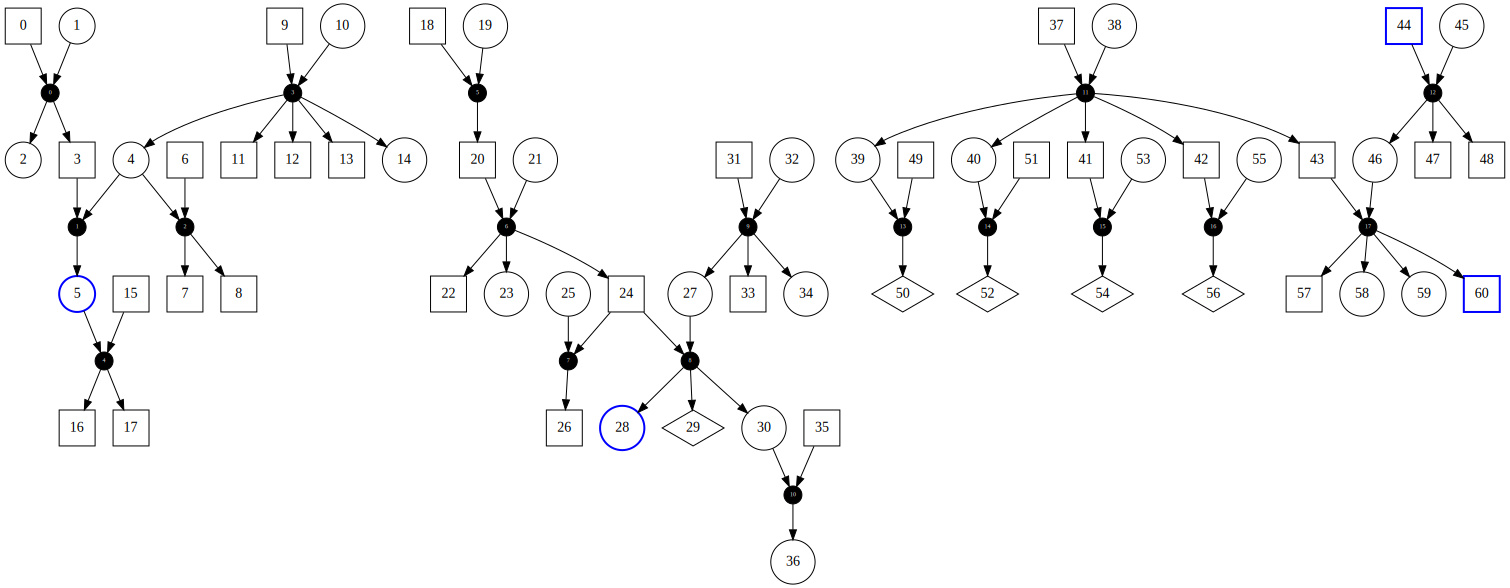

In [5]:
temp = PedigreeHMMFilter()
temp.preprocessData( graphs[ :3 ] )
temp.draw()

# Separate the labeled pedigrees

In [6]:
ad_graphs = [ ( graph, fbs ) for graph, fbs in graphs if graph.inheritancePattern == 'AD' ]
ar_graphs = [ ( graph, fbs ) for graph, fbs in graphs if graph.inheritancePattern == 'AR' ]
xl_graphs = [ ( graph, fbs ) for graph, fbs in graphs if graph.inheritancePattern == 'XL' ]
print( 'Number of graphs for - AD: %d AR: %d XL: %d'%( len( ad_graphs ), len( ar_graphs ), len( xl_graphs )) )

Number of graphs for - AD: 132 AR: 197 XL: 98


# Specify assumptions on the latent states

### An autosomal dominant diagnosis implies that the person has either AA, Aa or aA autosomes, autosomal recessive implies that the person has AA, X-Linked recessive implies that females have XX, males have XY and unknowns have either XX or XY 

In [7]:
def addLatentStateFromDiagnosis( graph, ip_type ):

    if( ip_type == 'AD' ):
        for node in graph.nodes:
            if( graph.data[ node ] == 1 ):
                # Affected
                graph.setPossibleLatentStates( node, [ 0, 1 ] )
    elif( ip_type == 'AR' ):
        for node in graph.nodes:
            if( graph.data[ node ] == 1 ):
                # Affected
                graph.setPossibleLatentStates( node, [ 0 ] )
    elif( ip_type == 'XL' ):
        for node in graph.nodes:
            if( graph.groups[ node ] == 0 ):
                # Female
                if( graph.data[ node ] == 1 ):
                    graph.setPossibleLatentStates( node, [ 0 ] )
            elif( graph.groups[ node ] == 1 ):
                # Male
                if( graph.data[ node ] == 1 ):
                    graph.setPossibleLatentStates( node, [ 0 ] )
            else:
                # Unknown sex
                if( graph.data[ node ] == 1 ):
                    graph.setPossibleLatentStates( node, [ 0, 3 ] )

### Because these are rare diseases, will assume that exactly one root is a carrier.
To do this, will select the root with the most affected descendents.  If there
is a tie, then will use the candidate root with the fewest non-affected descendents.

In [8]:
def selectAffectedRoot( graph ):
    n_affected_below = {}
    n_unaffected_below = {}
    for node in graph.backwardPass():
        n_affected_below[ node ] = 0
        n_unaffected_below[ node ] = 0
        if( graph.data[ node ] == 1 ):
            n_affected_below[ node ] += 1
        else:
            n_unaffected_below[ node ] += 1
        for children in graph.getChildren( node ):
            for child in children:
                if( child in n_affected_below ):
                    n_affected_below[ node ] += n_affected_below[ child ]
                    n_unaffected_below[ node ] += n_unaffected_below[ child ]
                
    n_affected_below_roots = dict( [ ( root, n_affected_below[ root ] ) for root in graph.roots ] )
    n_unaffected_below_roots = dict( [ ( root, n_unaffected_below[ root ] ) for root in graph.roots ] )
    
    max_val = np.max( np.array( list( n_affected_below_roots.values() ) ) )
    selections = [ root for root, val in n_affected_below_roots.items() if val == max_val ]
    
    if( len( selections ) > 1 ):
        # Use n_unaffected_below_roots as a tie breaker
        n_unaffected_below_roots = dict( [ ( root, val ) for root, val in n_unaffected_below_roots.items() if root in selections ] )
        min_val = np.min( np.array( list( n_unaffected_below_roots.values() ) ) )
        selections = [ root for root, val in n_unaffected_below_roots.items() if val == min_val and root in selections ]
        
        # If there are still multiple possibilities, just pick the first one
    return selections[ 0 ]

In [9]:
def sexToCarrierState( graph, node ):
    if( graph.groups[ node ] == 0 ):
        return [ 0, 1 ]
    elif( graph.groups[ node ] == 1 ):
        return [ 0 ]
    elif( graph.groups[ node ] == 2 ):
        return [ 0, 1, 3 ]
    
def sexToNotCarrierState( graph, node ):
    if( graph.groups[ node ] == 0 ):
        return [ 2 ]
    elif( graph.groups[ node ] == 1 ):
        return [ 1 ]
    elif( graph.groups[ node ] == 2 ):
        return [ 2, 4 ]
        
def setGraphRootStates( graph, ip_type ):
    if( ip_type == 'AD' ):
        affected_root = selectAffectedRoot( graph )
        graph.setPossibleLatentStates( affected_root, [ 0, 1 ] )
        for root in filter( lambda x: x!=affected_root, graph.roots ):
            graph.setPossibleLatentStates( root, [ 2 ] )
    elif( ip_type == 'AR' ):
        affected_root = selectAffectedRoot( graph )
        graph.setPossibleLatentStates( affected_root, [ 0, 1 ] )
        for root in filter( lambda x: x!=affected_root, graph.roots ):
            graph.setPossibleLatentStates( root, [ 2 ] )
    elif( ip_type == 'XL' ):
        affected_root = selectAffectedRoot( graph )
        graph.setPossibleLatentStates( affected_root, sexToCarrierState( graph, affected_root ) )
        for root in filter( lambda x: x!=affected_root, graph.roots ):
            graph.setPossibleLatentStates( root, sexToNotCarrierState( graph, root ) )

# Will compare inheritance patterns using E[ P( Θ | Y ) ]

### P( Θ | Y ) ∝ P( Y | Θ )P( Θ )
- When we use a point estimate for P( Θ ), then we can compare P( Θ | Y ) values directly.
- Otherwise, estimate E[ P( Θ | y ) ] using gibbs sampling:
$$
E_{\theta}[ P( \theta | Y ) ] \propto E_{\theta \sim P( \theta | X, Y ) }E_{ X \sim P( X | \theta, Y ) }[ \frac{ P( Y | \theta ) }{ P( X, Y | \theta ) } ]
$$

#### Logic for assumption that XL cannot have male to male transitions

In [10]:
def maleToMale( graph ):
    graph, fbs = graph
    for e, ( parents, children ) in enumerate( zip( graph.edge_parents, graph.edge_children ) ):
        father_affected = [ 1 for parent in parents if graph.attrs[ parent ][ 'sex' ] == 1 and graph.data[ parent ] == 1 ]
        sons_affected = [ 1 for child in children if graph.attrs[ child ][ 'sex' ] == 1 and graph.data[ child ] == 1 ]        
        if( len( father_affected ) > 0 and len( sons_affected ) > 0 ):
            return True
    return False

In [11]:
def evaluationGraphs( graph_and_fbs ):
    
    graph, fbs = graph_and_fbs

    graph_sex_matters = graph if isinstance( graph, PedigreeSexMatters ) else PedigreeSexMatters.fromPedigree( graph )
    graph_sex_doesnt_matters = graph if isinstance( graph, Pedigree ) else Pedigree.fromPedigreeSexMatters( graph )
    
    ad_graph = copy.deepcopy( graph_sex_doesnt_matters )
    ar_graph = copy.deepcopy( graph_sex_doesnt_matters )
    xl_graph = copy.deepcopy( graph_sex_matters )
    
    addLatentStateFromDiagnosis( ad_graph, 'AD' )
    setGraphRootStates( ad_graph, 'AD' )
    
    addLatentStateFromDiagnosis( ar_graph, 'AR' )
    setGraphRootStates( ar_graph, 'AR' )
    
    addLatentStateFromDiagnosis( xl_graph, 'XL' )
    setGraphRootStates( xl_graph, 'XL' )
    
    return ( ad_graph, fbs ), ( ar_graph, fbs ), ( xl_graph, fbs )

## General evaluation

In [12]:
def onlineMeanUpdate( mean, val, N ):
    return mean + ( val - mean ) / N

def normalizedScores( ad_score, ar_score, xl_score ):
    normalizer = np.logaddexp.reduce( [ ad_score, ar_score, xl_score ] )
    probs = np.array( [ np.exp( ad_score - normalizer ), np.exp( ar_score - normalizer ), np.exp( xl_score - normalizer ) ] )
    return probs

def distributionComparison( graph, ad_priors, ar_priors, xl_priors, samples=400 ):

    # Fill in assumptions that we can make about each graph
    ad_graph, ar_graph, xl_graph = evaluationGraphs( graph )
    
    # Make the models
    ad_eval = AutosomalDominant( [ ad_graph ], priors=ad_priors, method='Gibbs' )
    ar_eval = AutosomalRecessive( [ ar_graph ], priors=ar_priors, method='Gibbs' )
    xl_eval = XLinkedRecessive( [ xl_graph ], priors=xl_priors, method='Gibbs' )

    # See if there are fathers and sons who are affected to rule out XL
    male_to_male = maleToMale( graph )

    ad_score, ar_score, xl_score = 0.0, 0.0, 0.0
    
    for i in range( samples ):
        
        # Sample Θ
        ad_eval.sampleParams()
        ar_eval.sampleParams()
        xl_eval.sampleParams()
        
        # Update the scores
        ad_score = onlineMeanUpdate( ad_score, ad_eval.marginal(), i+1 )
        ar_score = onlineMeanUpdate( ar_score, ar_eval.marginal(), i+1 )
        if( male_to_male == False ):
            xl_score = onlineMeanUpdate( xl_score, xl_eval.marginal(), i+1 )     
            
    probs = normalizedScores( ad_score, ar_score, xl_score )
    
    # Sort the scores and return the corresponding inheritance pattern
    ad_comp = ( ad_score, 'AD' )
    ar_comp = ( ar_score, 'AR' )
    xl_comp = ( xl_score, 'XL' )
    
    possibilities = [ ad_comp, ar_comp, xl_comp ] if male_to_male == False else [ ad_comp, ar_comp ]
    return sorted( possibilities, key=lambda x: x[ 0 ] )[ -1 ][ 1 ], probs

In [13]:
ad_priors = autosomalDominantPriors( prior_strength=10000.0 )
ar_priors = autosomalRecessivePriors( prior_strength=10000.0 )
xl_priors = xLinkedRecessivePriors( prior_strength=10000.0 )

In [14]:
results = []

In [16]:
N = 300
n_graphs = len( ad_graphs ) + len( ar_graphs ) + len( xl_graphs )
with tqdm( total=n_graphs ) as pbar:
    for graph in ad_graphs:
        ip, probs = distributionComparison( graph, ad_priors, ar_priors, xl_priors, samples=N )
        results.append( ( graph, ip, 'AD' ) )
        pbar.update( 1 )
#         print( 'Study ID', graph[0].studyID, 'Prediction:', ip, 'True: AD', 'probs', probs )

    for graph in ar_graphs:
        ip, probs = distributionComparison( graph, ad_priors, ar_priors, xl_priors, samples=N )
        results.append( ( graph, ip, 'AR' ) )
        pbar.update( 1 )
#         print( 'Study ID', graph[0].studyID, 'Prediction:', ip, 'True: AR', 'probs', probs )

    for graph in xl_graphs:
        ip, probs = distributionComparison( graph, ad_priors, ar_priors, xl_priors, samples=N )
        results.append( ( graph, ip, 'XL' ) )
        pbar.update( 1 )
#         print( 'Study ID', graph[0].studyID, 'Prediction:', ip, 'True: XL', 'probs', probs )

100%|██████████| 427/427 [10:21:04<00:00, 91.74s/it]   


In [17]:
_, predicted, true = list( zip( *results ) )
predicted = np.array( predicted )
true = np.array( true )

In [18]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

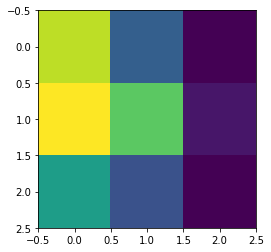

In [19]:
mat = confusion_matrix( true, predicted, labels=[ 'AD', 'AR', 'XL' ] )
plt.imshow( mat )

In [20]:
def classAccuracy( label, predicted, true ):
    predicted_label = predicted[ true == label ]
    return ( predicted_label == label ).sum() / predicted_label.shape[ 0 ]

In [21]:
classAccuracy( 'AD', predicted, true )

0.6934306569343066

In [22]:
classAccuracy( 'AR', predicted, true )

0.40609137055837563

In [23]:
classAccuracy( 'XL', predicted, true )

0.061224489795918366

# Well it looks like this approach failed